# My first CTMC algorithm

My first attempt at fitting a Continous Time Markov Chain to simulated data in a toy problem. Mathematical background on how to build the likelihood can be found in [here](http://www.mathematik.uni-karlsruhe.de/ianm3/~jahnke/media/medijasc2007.pdf).

### Simulate toy problem

We will first start off with a very simple 3 state CTMC model, before going into epidemic specific models.

We will model a single individual suffering from depression, moving between the 3 states of susceptible, depressed, and happy.

The transitions will be defined as follows:

\begin{align}
S \to D & &\text{with rate} & &\beta,\\
D \to H & &\text{with rate} & &\gamma,\\
H \to S & &\text{with rate} & &\omega,\\
S \to H & &\text{with rate} & &\nu.\\
\end{align}

For simplicity, we can define the set of parameters to be $\boldsymbol{\theta} = (\beta, \gamma, \omega, \nu)$. For our toy problem, let us set $\boldsymbol{\theta} = ( 2, 0.125, 0.3, 1)$, with an inital start point at S, i.e. $\boldsymbol{n} = (1,0,0)$. Note that our units of time are days.


In [82]:
class ctmc:    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma, omega, nu,init):
        self.parameters = (beta, gamma, omega,nu)
        assert len(init)==3, "Number of states given is not 3"
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        
        def infection():
            #being depressed
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery to happiness 
            self.current[1] -=1
            self.current[2] +=1
        def waning():
            #back to susceptible
            self.current[2] -=1
            self.current[0] +=1
        def vacc():
            #susceptible to happy
            self.current[0] -=1
            self.current[2] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : infection,
            1 : recovery,
            2 : waning,
            3 : vacc,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]
        recov = gamma * self.current[1]
        wane = omega * self.current[2]
        vac = nu * self.current[0]
        total = trans + recov + wane + vac
        
        #Record current rates
        self.currentrates = (trans, recov, wane, vac)
        
        #Draw a transition time
        dt = -1*np.log(np.random.random())/total#np.random.exponential(1/total) #numpy uses scale parameter, inverse of rate
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(4, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            S,D,H, = self.current.copy()
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                
                observations.append((time,dt,s,S,D,H))
        return observations

Now that we have our functions and simulation coded, let's run a simulation and observe a possible path for this kind of CTMC, or epidemic. Let's plot the path of the state space over 400 days.

(149, 6)


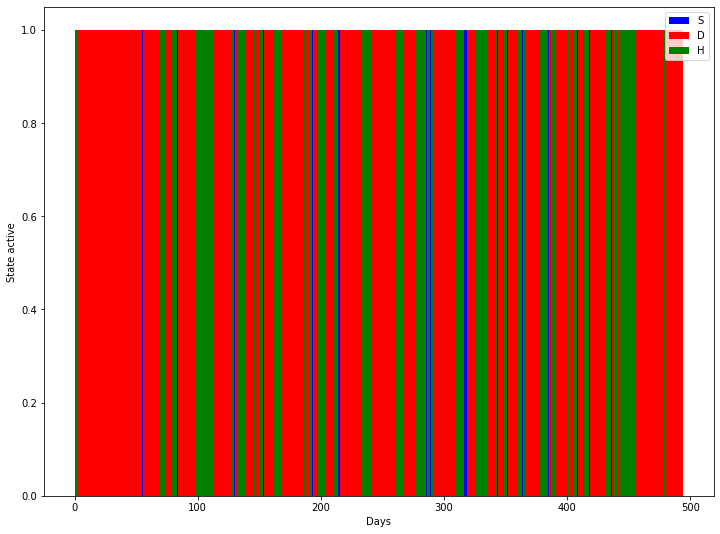

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


init = np.array((1,0,0))
beta = 2
gamma = 0.125
omega = 0.3
nu = 1

toy = ctmc(beta, gamma, omega,nu, init)
obs = toy.simulate(500)

data = pd.DataFrame(obs, columns = ['time','dt','transition','S','D','H'])
data.time = data.time.shift(1).fillna(0)
#print(data)
print(data.shape)
fig,ax = plt.subplots(figsize=(12,9))
ax.bar(data.time, data.S, width=data.dt, align='edge', label='S', color='b')
ax.bar(data.time, data.D, width=data.dt, align='edge', label='D', color = 'r')
ax.bar(data.time, data.H, width=data.dt, align='edge', label='H', color='g')
ax.set_xlabel("Days")
ax.set_ylabel("State active")
plt.legend()
plt.show()

In [101]:
import pystan

stancode = """
data {
    int<lower=0> N; //length of data
    real<lower=0> dt[N]; //time
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> bet;
    real<lower=0> gamm;
    real<lower=0> omega;
    real<lower=0> nu;
}
model {
    int state;
    bet ~ gamma(1.5,1.5);
    gamm ~ gamma(1.5,1.5);
    omega ~ gamma(1.5,1.5);
    nu ~ gamma(1.5,1.5);
    
    for (n in 1:N){
        state = transitions[n];
        if (state == 0) {
            //Infection
            dt[n] ~ exponential(
            bet
            );
            }
        else if (state == 1) {    
            //Recovery
            dt[n] ~ exponential(
                gamm 
            );
            }
        else if (state == 2) {
            //Waning
            dt[n] ~ exponential(
                omega 
            );
            }        
        else if (state == 3) {
            //Improvement
            dt[n] ~ exponential(
                nu 
            );
            }
    } 
}
"""

data_dict = {
    'N': data.shape[0],
    'dt': data['dt'].values,
    'transitions': data.transition.astype(int)
}

sm = pystan.StanModel(model_code=stancode)
iterations = 2500
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)
print(fit)
print(toy.parameters)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe5a02827384fa2b16a60735f6106b6e NOW.


Inference for Stan model: anon_model_fe5a02827384fa2b16a60735f6106b6e.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet     3.05    0.01   0.46    2.2   2.73   3.03   3.34   4.01   1962    1.0
gamm    0.13  4.5e-4   0.02   0.09   0.11   0.13   0.14   0.17   1961    1.0
omega   0.35  1.2e-3   0.05   0.26   0.31   0.35   0.38   0.45   1768    1.0
nu      2.66    0.01   0.67   1.52   2.21    2.6   3.04   4.13   2081    1.0
lp__  -238.0    0.04   1.45 -241.6 -238.7 -237.6 -236.9 -236.2   1054   1.01

Samples were drawn using NUTS at Mon Jan  6 16:11:23 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
(2, 0.125, 0.3, 1)


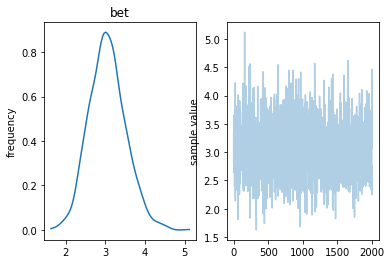

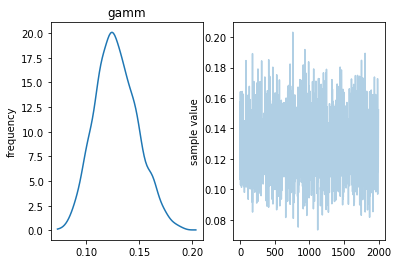

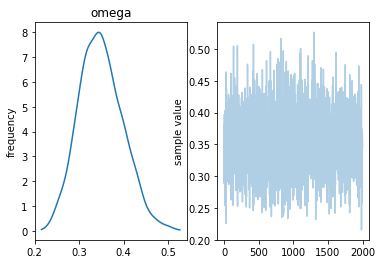

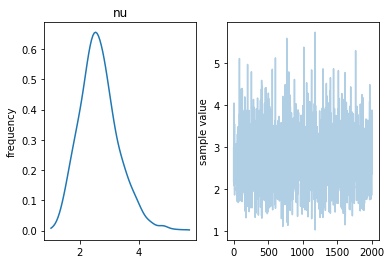

In [102]:
fit.plot(pars=['bet'])
fit.plot(pars=['gamm'])
fit.plot(pars=['omega'])
fit.plot(pars=['nu'])
plt.show()

### Maximum Likelihood Estimate

We know from our mathematical source (equation 13) that the Maximum Likelihood Estimate for the rates $r_{i,j}$ are:

\begin{align}
\hat{r_{i,j}} & = \frac{N_{i,j}} {\sum dt_{i} }\\
\end{align}

In [113]:
##MLE
bet_hat = data.loc[data.transition==0].S.sum()/data.loc[data.S==1].dt.sum()
gamm_hat = data.loc[data.transition==1].D.sum() /data.loc[data.D==1].dt.sum()
omeg_hat = data.loc[data.transition==2].H.sum() / data.loc[data.H==1].dt.sum()
nu_hat = data.loc[data.transition==3].S.sum() /data.loc[data.S==1].dt.sum() 
print(bet_hat, gamm_hat, omeg_hat, nu_hat)
print(toy.parameters)

2.440701275470394 0.1251988413346497 0.34203036585691 0.833410191624037
(2, 0.125, 0.3, 1)


### Simulate toy problem

First we will simulate some data. We will use a a simple 3 state model, a typical SIRS epidemic model with perfect vaccination, on a closed population of 100 people.

The transitions will be defined as follows:

\begin{align}
S \to I & &\text{with rate} & &\beta \frac{SI}{N},\\
I \to R & &\text{with rate} & &\gamma I,\\
R \to S & &\text{with rate} & &\omega R.\\
\end{align}

For simplicity, we can define the set of parameters to be $\boldsymbol{\theta} = (\beta, \gamma, \omega)$. For our toy problem, let us set $\boldsymbol{\theta} = ( 2, 0.125, 1/400)$, with an initial state (starting population) completely susceptible with 1 infected seed, i.e. $\boldsymbol{n} = (99,1, 0)$. Note that our units of time are days.

In [115]:
class sirvs:
    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma, omega, init):
        self.parameters = (beta, gamma, omega)
        assert len(init)==3, "Number of states given is not 3"
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        #0 = S, 1 = I, 2 = R, 3 = V 
        def infection():
            #Infected transmission
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery 
            self.current[1] -=1
            self.current[2] +=1
        def waning():
            #waning immunity
            self.current[2] -=1
            self.current[0] +=1
        def vacc():
            #vaccination
            self.current[0] -=1
            self.current[3] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : infection,
            1 : recovery,
            2 : waning,
            3 : vacc,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]*self.current[1]/self.totalpop
        recov = gamma * self.current[1]
        wane = omega * self.current[2]
        #vac = nu * self.current[1] * self.current[0]/self.totalpop
        total = trans + recov + wane #+ vac
        
        #Record current rates
        self.currentrates = (trans, recov, wane)
        
        #Draw a transition time
        dt = -1*np.log(np.random.random())/total#np.random.exponential(1/total) #numpy uses scale parameter, inverse of rate
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(3, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            S,I,R = self.current.copy()
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                
                observations.append((time,dt,s,S,I,R))
        return observations

Now that we have our functions and simulation coded, let's run a simulation and observe a possible path for this kind of CTMC, or epidemic. Let's see how the state space looks after 20 days.

           time        dt  transition   S   I   R
1078  99.420121  0.000164           2   9  23  68
1079  99.483665  0.063543           1  10  23  67
1080  99.805781  0.322116           1  10  22  68
1081  99.874242  0.068461           1  10  21  69
1082  99.928657  0.054415           0  10  20  70
(1083, 6)


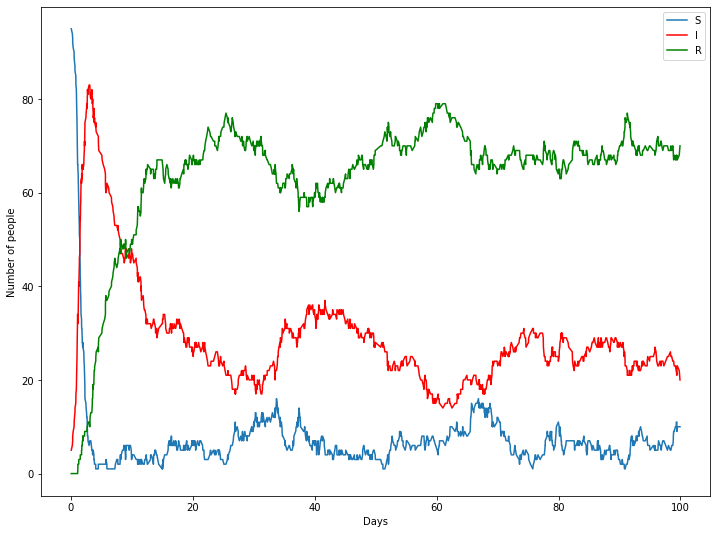

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


init = np.array((95,5,0))
beta = 2
gamma = 0.125
omega = 1/20

toy = sirvs(beta, gamma, omega, init)
obs = toy.simulate(100)

data2 = pd.DataFrame(obs, columns = ['time','dt','transition','S','I','R'])
print(data2.tail())
print(data2.shape)
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(data2.time, data2.S, label='S')
ax.plot(data2.time, data2.I, label='I', color = 'r')
ax.plot(data2.time, data2.R, label='R', color='g')
ax.set_xlabel("Days")
ax.set_ylabel("Number of people")
plt.legend()
plt.show()

In [141]:
print((toy.current[0]+1)*(toy.current[1]-1)*beta/toy.totalpop)
toy.currentrates, toy.current, toy.totalpop


3.78


((3.78, 2.625, 3.5), [8, 22, 70], 100)

Now that we have our data, let's see how we would do inference. As a reminder, the parameters we want to be inferring are $\boldsymbol{\theta} = (\beta, \gamma, \omega)$.

In [145]:
import pystan

stancode = """
data {
    int<lower=0> N; //length of data
    int<lower=1> Pop; //total size of population
    real<lower=0> dt[N]; //time
    int<lower=0> Sus[N];
    int<lower=0> I[N];
    int<lower=0> R[N];
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> bet;
    real<lower=0> gamm;
    real<lower=0> omega;
}
model {
    int state;
    bet ~ gamma(1,1.5);
    gamm ~ gamma(1,1.5);
    omega ~ gamma(1,1.5);
    
    for (n in 1:N){
        state = transitions[n];
        if (state == 0) {
            //Infection
            dt[n] ~ exponential(
            bet*Sus[n]*I[n] / Pop
            );
            }
        else if (state == 1) {    
            //Recovery
            dt[n] ~ exponential(
                gamm * I[n]
            );
            }
        else if (state == 2) {
            //Waning
            dt[n] ~ exponential(
                omega * R[n]
            );
            }
    } 
}
"""

data_dict = {
    'N': data2.shape[0],
    'Pop': sum(init),
    'dt': data2['dt'].values,
    'Sus': data2.S.values.astype(int),
    'I': data2.I.values.astype(int),
    'R': data2.R.values.astype(int),
    'transitions': data2.transition.astype(int)
}

sm = pystan.StanModel(model_code=stancode)
iterations = 1000
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ea5c09b895aaec8d022e7fe3008fafe NOW.


Inference for Stan model: anon_model_4ea5c09b895aaec8d022e7fe3008fafe.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet     4.44  6.5e-3   0.21   4.03    4.3   4.44   4.59   4.85   1067    1.0
gamm    0.34  5.5e-4   0.02   0.31   0.33   0.34   0.35   0.37   1010    1.0
omega   0.14  2.4e-4 7.8e-3   0.13   0.14   0.14   0.15   0.16   1038    1.0
lp__  1510.3    0.05   1.19 1507.1 1509.8 1510.5 1511.1 1511.6    488    1.0

Samples were drawn using NUTS at Tue Jan  7 11:45:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


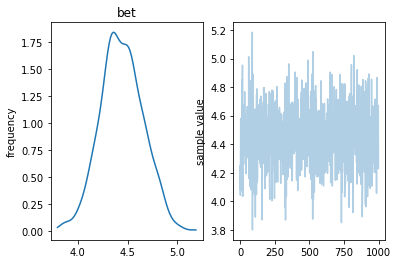

In [146]:
print(fit)
fit.plot(pars=['bet'])

plt.show()

In [147]:
toy.parameters

(2, 0.125, 0.05)

In [137]:

##MLE
#doesn't take into account the S, I and R quantities
bet_hat = data2.loc[data2.transition==0].shape[0]/data2.loc[data2.transition==0].dt.sum()
gamm_hat = data2.loc[data2.transition==1].shape[0] /data2.loc[data2.transition==1].dt.sum()
omeg_hat = data2.loc[data2.transition==2].shape[0] / data2.loc[data2.transition==2].dt.sum()
print(bet_hat, gamm_hat, omeg_hat)
print(toy.parameters)

13.436713997448425 10.583838875863147 11.263268838775705
(2, 0.125, 0.05)


In [134]:
data

,time,dt,transition,S,I,R
0,0.018829,0.018829,0,95,5,0
1,0.032327,0.013499,0,94,6,0
2,0.098998,0.066670,0,93,7,0
3,0.130801,0.031804,0,92,8,0
4,0.197779,0.066978,0,91,9,0
5,0.308752,0.110974,1,90,10,0
6,0.393664,0.084912,0,90,9,1
7,0.447075,0.053411,0,89,10,1
8,0.535914,0.088838,0,88,11,1
9,0.678703,0.142789,0,87,12,1
